In [18]:
import networkx as nx 
import pandas as pd
import matplotlib.pyplot as plt

## Some terminology

User looking for recommendation: **Main user** <br/>
Other users: **Other users/ users**

## Finding relations between users 

We will generate relationships (weights) between the main user and other users. The suggestions/ratings of a user having a better relationship with main user will have more weightage over that of other users. <br />
The relationship will be denotated by a directed edge from the main user to the other user.

In [19]:
def relationship_among_users(G, user, deg):
    '''
        description:
            given main user, add weighted edges between 
            main user and other users based on common nodes
    
        parameters:
            G: the bipartite graph (directed, weighted)
            user: user who is looking for recommendations (main user)
            deg: no. of anime main user has reviwed

        returns: 
            void
    '''

    u = user

    for w in users:
        weight = 0.0
        for v in G.neighbors(u): 
            if G.nodes[v]['label'] == 'anime' and G.has_edge(w, v):
                weight += (1/G.out_degree(v))

        weight /= deg

        if (weight != 0):
            G.add_edge(u, w, weight=weight) 

## Recommended anime list

Based on main user's relationships and the ratings given to anime by other users, a list of anime_ids is returned in sorted order (most recommended anime first)

In [52]:
def recommendation_list(G, user, deg, include_already_watched=False, top_n=None):
    '''
        description: 
            Given a graph with connections (weghted, directed) among users
            and the user who needs recommendations,
            returns sorted list of recommended animes 

        parameters:
            G: Graphs with connection among users 
                (graph after implementing 'relationship_among_users()')
            user: User who is looking for recommendations (main user)
            deg: number of anime main user has reviewed
            include_already_watched: (default = false)
                if true, the list of anime main user has already watched will 
                also be included in the recommendation list
            top_n: (default = None)
                returns only the 'top_n' animes

        returns: 
            sorted list of recommended anime
                eg. [(anime1, score1), (anime2, score2), (anime3, score3)]
    '''

    u = user
    possible_anime = set()

    for n in G.neighbors(u):
        if G.nodes[n]['label'] == 'anime':
            for other_users in G.neighbors(n):
                for anime in G.neighbors(other_users):
                    if G.nodes[anime]['label'] == 'anime':
                        possible_anime.add(anime)

    suggestion_dict = {}

    for anime in possible_anime:
        score = 0
        for w in G.neighbors(anime):
            if G.has_edge(u, w):
                score += (G[u][w]['weight'] * G[w][anime]['rating'] / (deg if w==u else G.out_degree(w)))

        suggestion_dict[anime] = score

    # remove already watched anime
    if not include_already_watched:
        for already_watched in G.neighbors(u):
            if G.nodes[n]['label'] == 'anime':
                del suggestion_dict[already_watched]

    return sorted(list(suggestion_dict.items()), key=(lambda x : x[1]), reverse=True)[:top_n]


## Fetch anime title

Based on the ids returned in 'recommendation_list()' function, the respective anime titles and plots are returned.

In [47]:
anime_data = pd.read_csv('anime.csv')
anime_data = anime_data.set_index('MAL_ID')
anime_data = anime_data.rename(columns={'Score' : 'Community rating'})

def fetch_anime_titles(anime_list):
    return  anime_data.loc[anime_list][['Name', 'Community rating']]

# Testing

Let us try the above algorithms over a small network to understand how it works.

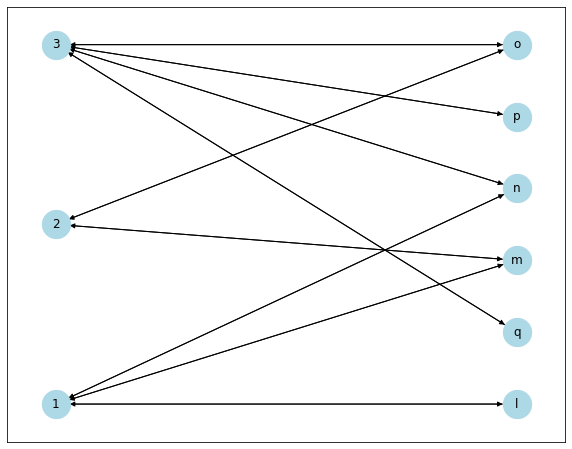


weights among users: {(2, 1): 0.25, (2, 2): 0.5, (2, 3): 0.25}



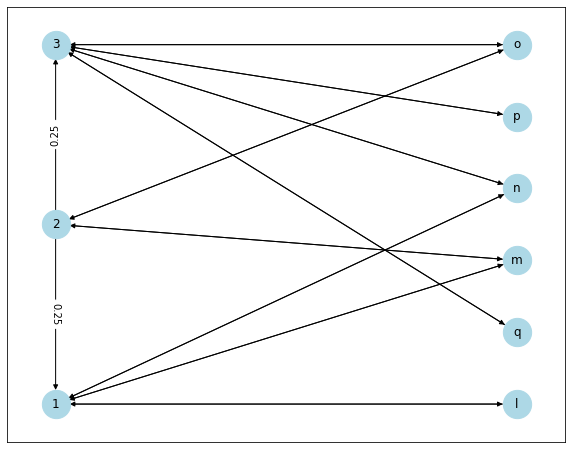


Recommended list of anime ids: [('m', 1.6666666666666667), ('o', 1.5625), ('n', 0.7291666666666667), ('l', 0.4166666666666667), ('q', 0.3125), ('p', 0.3125)]



In [22]:
G = nx.Graph()

users = [1,2,3]
anime = ['l','m','n','o','p','q']

G.add_nodes_from(users, label='user')
G.add_nodes_from(anime, label='anime')
G.add_edges_from([(1, 'l', {'rating' : 5}), 
                  (1, 'm', {'rating' : 5}),
                  (1, 'n', {'rating' : 5}),
                  (2, 'm', {'rating' : 5}),
                  (2, 'o', {'rating' : 5}),
                  (3, 'n', {'rating' : 5}),
                  (3, 'o', {'rating' : 5}),
                  (3, 'p', {'rating' : 5}),
                  (3, 'q', {'rating' : 5})])

main_user = 2
deg = G.degree(main_user)

G = nx.DiGraph(G)

pos = nx.bipartite_layout(G, users)

plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos=pos, node_size=800, node_color='lightblue')
plt.show()

# generating relationships among users
relationship_among_users(G, main_user, deg)

edge_weights = nx.get_edge_attributes(G, 'weight')
print('\n===================================')
print('weights among users:', edge_weights)
print('===================================\n')

plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos=pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_weights)
plt.show()

#getting the recommended list of anime ids
recommended_anime_ids = recommendation_list(G, main_user, deg)

print('\n===================================')
print('Recommended list of anime ids:', recommended_anime_ids)
print('===================================\n')


## Actual data

Lets try it on our actual data now. 

dataset: https://www.kaggle.com/hernan4444/anime-recommendation-database-2020?select=rating_complete.csv

I made some chnages to the dataset
1. Added a prefix 'a' to the anime_ids so they dont mix up with the user_ids
2. I used only the top 500000 rows as the process is time consuming

In [38]:
data = pd.read_csv('rating_complete.csv', nrows=1000)
data['anime_id'] = 'a' + data['anime_id'].astype(int).astype(str)
data_users = data['user_id']
data_anime = data['anime_id']

In [54]:
# Take a look at our data
data.head()

,user_id,anime_id,rating
0,0,a430,9
1,0,a1004,5
2,0,a3010,7
3,0,a570,7
4,0,a2762,9


In [55]:
# Generating the graph

G = nx.Graph()
G = nx.from_pandas_edgelist(data, 'user_id', 'anime_id', edge_attr='rating')

G.add_nodes_from(data_users, label='user')
G.add_nodes_from(data_anime, label='anime')

main_user = 2
deg = G.degree(main_user)

G = nx.DiGraph(G)

## plotting the graph takes a lot of time

# pos = nx.bipartite_layout(G, users)

# plt.figure(figsize=(50, 40))
# # nx.draw_networkx(G, pos=pos, node_size=100, node_color='lightblue', edge_color='grey' with_labels=False)
# nx.draw_networkx(G, node_size=100, node_color='lightblue', edge_color='grey', with_labels=False)
# plt.show()


In [53]:
# generating relationships among users
relationship_among_users(G, main_user, deg)

edge_weights = nx.get_edge_attributes(G, 'weight')
print('\n===================================')
print('weights among users:', edge_weights)
print('===================================\n')

# plt.figure(figsize=(10, 8))
# nx.draw_networkx(G, pos=pos, node_size=800, node_color='lightblue')
# nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_weights)
# plt.show()

#getting the recommended list of anime ids
recommended_anime_scores = recommendation_list(G, user=main_user, deg=deg, top_n=20)

print('\n===================================')
print('Recommended list of anime ids and their calculated scores: ', recommended_anime_scores)
print('===================================\n')

recommended_anime_ids = [ int(pair[0][1:]) for pair in recommended_anime_scores]

# fetch anime information from their ids
fetch_anime_titles(recommended_anime_ids)


weights among users: {(2, 1): 0.11993464052287582, (2, 2): 0.6624183006535947, (2, 3): 0.13137254901960785}


Recommended list of anime ids and their calculated scores:  [('a1535', 0.14036566717555732), ('a11061', 0.14036566717555732), ('a2904', 0.1332223869940133), ('a9253', 0.13229498843131388), ('a1575', 0.13187793272014053), ('a263', 0.1298859413046264), ('a30276', 0.12954910474882256), ('a28171', 0.12954910474882256), ('a16498', 0.12854148703075366), ('a20', 0.12854148703075366), ('a1735', 0.12854148703075366), ('a33486', 0.12621265905943568), ('a34134', 0.1250482450737767), ('a15451', 0.12023379286355064), ('a23755', 0.11981673715237728), ('a22535', 0.11772492460401889), ('a26055', 0.11689734717416378), ('a20899', 0.11689734717416378), ('a1604', 0.11689734717416378), ('a270', 0.11689734717416378)]



,Name,Community rating
MAL_ID,,
1535,Death Note,8.63
11061,Hunter x Hunter (2011),9.1
2904,Code Geass: Hangyaku no Lelouch R2,8.91
9253,Steins;Gate,9.11
1575,Code Geass: Hangyaku no Lelouch,8.72
263,Hajime no Ippo,8.75
30276,One Punch Man,8.57
28171,Shokugeki no Souma,8.29
16498,Shingeki no Kyojin,8.48
